# Beijing Air Quality Forecasting Starter Notebook

In [ ]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the datasets
train = pd.read_csv('/content/drive/MyDrive/Time_Series_Assessment/data/train.csv')
test = pd.read_csv('//content/drive/MyDrive/Time_Series_Assessment/data/test.csv')


# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [ ]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [ ]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [ ]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)


# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

In [ ]:
#Check the missing datas
print(train.isnull().sum())

non_missing_pm25 = train['pm2.5'].notnull().sum()
print("Non-missing pm2.5 values:", non_missing_pm25)

No            0
DEWP          0
TEMP          0
PRES          0
Iws           0
Is            0
Ir            0
cbwd_NW       0
cbwd_SE       0
cbwd_cv       0
pm2.5      1921
dtype: int64
Non-missing pm2.5 values: 28755


##Dropping the values that holds NAN values

In [ ]:
train = train.dropna(subset=['pm2.5'])

# Separate features and target

- Feel free to drop any non-essential columns like that you think might not contribute to modeling.

In [ ]:
X_train = train.drop(['pm2.5', 'No'], axis=1)
y_train = train['pm2.5']

In [ ]:
# Reshape data for LSTM input
# LSTM models require data in the shape (samples, timesteps, features).
# Here, the data is reshaped to add a "timesteps" dimension.

X = []
Y = []

timesteps = 24

for i in range(timesteps, len(X_train)):
    X.append(X_train.iloc[i-timesteps:i].values)
    Y.append(y_train.iloc[i])

X_train = np.array(X)
y_train = np.array(Y)

print(X_train)
print(y_train)


[[[-1.23445618 -1.34840816  0.3459432  ... -0.69054212  1.36608457
   -0.52209647]
  [-1.16517184 -1.34840816  0.3459432  ... -0.69054212  1.36608457
   -0.52209647]
  [-0.88803447 -1.43038563  0.44332765 ... -0.69054212  1.36608457
   -0.52209647]
  ...
  [-0.6108971  -1.43038563  1.02763429 ... -0.69054212  1.36608457
   -0.52209647]
  [-0.68018145 -1.5123631   1.12501873 ... -0.69054212  1.36608457
   -0.52209647]
  [-0.68018145 -1.5123631   1.02763429 ... -0.69054212  1.36608457
   -0.52209647]]

 [[-1.16517184 -1.34840816  0.3459432  ... -0.69054212  1.36608457
   -0.52209647]
  [-0.88803447 -1.43038563  0.44332765 ... -0.69054212  1.36608457
   -0.52209647]
  [-0.6108971  -1.43038563  0.54071209 ... -0.69054212  1.36608457
   -0.52209647]
  ...
  [-0.68018145 -1.5123631   1.12501873 ... -0.69054212  1.36608457
   -0.52209647]
  [-0.68018145 -1.5123631   1.02763429 ... -0.69054212  1.36608457
   -0.52209647]
  [-0.6108971  -1.5123631   1.02763429 ... -0.69054212  1.36608457
   -0.

# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [ ]:
# define model
model = Sequential([
    LSTM(64, activation='tanh',
         kernel_regularizer=regularizers.l2(0.001),
         dropout=0.2, recurrent_dropout=0.2,
         input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

# Compile the model
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]  # RMSE metric
)

# Display the model architecture
model.summary()



/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# You can adjust the number of epochs and batch size to improve performance.
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split = 0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Epoch 1/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 25s 28ms/step - lambda: 118.7670 - loss: 14695.0195 - val_lambda: 92.6301 - val_loss: 15102.7920
Epoch 2/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - lambda: 97.0698 - loss: 9379.4385 - val_lambda: 82.8220 - val_loss: 11707.8379
Epoch 3/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 43s 32ms/step - lambda: 92.3467 - loss: 7051.8584 - val_lambda: 80.9044 - val_loss: 9968.4980
Epoch 4/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 37s 27ms/step - lambda: 93.9447 - loss: 6217.1641 - val_lambda: 80.2918 - val_loss: 8931.1953
Epoch 5/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - lambda: 97.3359 - loss: 5951.2217 - val_lambda: 79.4414 - val_loss: 8273.4150
Epoch 6/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - lambda: 98.0511 - loss: 5518.9609 - val_lambda: 80.0749 - val_loss: 7675.5615
Epoch 7/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - lambda: 98.3341 - loss: 5005.6035 - val_lambda: 79.3504 - val_loss: 7266.7158
Epoch 8/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - la

898/898 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step


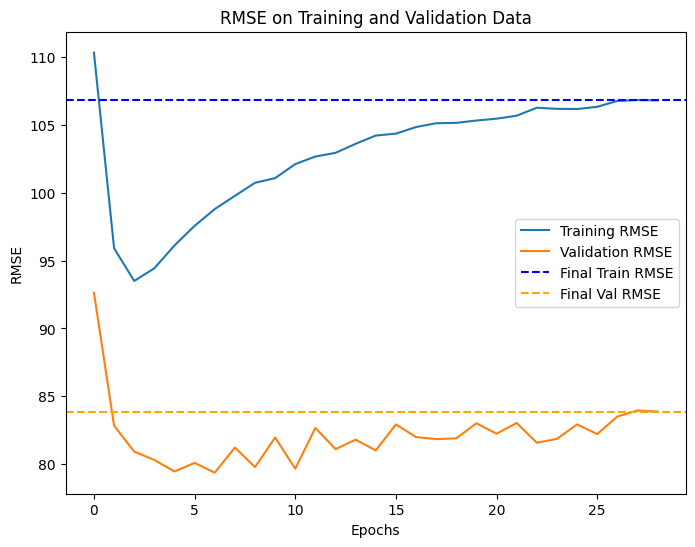

Final Training RMSE: 106.83
Final Validation RMSE: 83.86


In [ ]:
# Calculate predictions (optional if not used)
train_predictions = model.predict(X_train)

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['lambda'], label='Training RMSE')
plt.plot(history.history['val_lambda'], label='Validation RMSE')
plt.axhline(y=history.history['lambda'][-1], color='blue', linestyle='--', label='Final Train RMSE')
plt.axhline(y=history.history['val_lambda'][-1], color='orange', linestyle='--', label='Final Val RMSE')
plt.title('RMSE on Training and Validation Data')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

# Print final losses
print(f"Final Training RMSE: {history.history['lambda'][-1]:.2f}")
print(f"Final Validation RMSE: {history.history['val_lambda'][-1]:.2f}")

In [ ]:
# Prepare the test data
X_test = test.drop(['No'], axis=1)
X_test = np.expand_dims(X_test, axis=1)

# Make predictions on the test set using trained model to predict "pm2.5" concentrations
predictions = model.predict(X_test)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

# Convert predictions to integers
predictions = np.round(predictions).astype(int)

# Prepare the submission file
# Convert 'row ID' index to string and remove leading zeros for single-digit hours
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),  # Remove leading zeros for hours
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Save the file in CSV format for submission on Kaggle
submission.to_csv('/content/drive/MyDrive/Time_Series_Assessment/subm_fixed.csv', index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
